In [3]:
%pip install torch parameterfree pandas numpy scikit-learn matplotlib cloudpickle xgboost openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


### Load the data

In [1]:
import pandas as pd
df = pd.read_csv('data/sims_features1.csv')

### Helpful Sources about Architectures

+ If normalizing do it before activation https://forums.fast.ai/t/why-perform-batch-norm-before-relu-and-not-after/81293/4
+ What are residual networks https://arxiv.org/pdf/1512.03385.pdf
+ When building residual networks use pre-activation https://arxiv.org/abs/1603.05027
+ There is not one universal best normalization method https://proceedings.neurips.cc/paper/2021/hash/2578eb9cdf020730f77793e8b58e165a-Abstract.html
+ Adam is the standard optimizer but takes a lot of tuning. COCOB tunes automatically https://github.com/bremen79/parameterfree
+ Smaller batches tend to be better? (this seems to be with fixed epochs though so may not be relevant) https://arxiv.org/pdf/1804.07612.pdf

### Basic Architectures

In [2]:
from itertools import chain
import torch

class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, norm='l'):
        super().__init__()

        if norm == 'l': norm = [torch.nn.LayerNorm  (in_features)]
        if norm == 'b': norm = [torch.nn.BatchNorm1d(in_features)]

        input_norm   = norm or []
        output_layer = torch.nn.Linear(in_features=in_features, out_features=out_features)
        self.layers  = torch.nn.Sequential(*input_norm, output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class Mlp(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, norm='l'):
        super().__init__()

        def norm_layer(in_width, out_width, norm):
            norm = torch.nn.LayerNorm(out_width) if norm == 'l' else torch.nn.BatchNorm1d(out_width)
            return torch.nn.Sequential(torch.nn.Linear(in_features=in_width, out_features=out_width), norm, torch.nn.ReLU())

        def no_norm_layer(in_width, out_width):
            return torch.nn.Sequential(torch.nn.Linear(in_features=in_width, out_features=out_width), torch.nn.ReLU())

        def layer(in_width, out_width, norm):
            if norm:
                return norm_layer(in_width, out_width, norm)
            else:
                return no_norm_layer(in_width, out_width)

        width = width or in_features

        input_layer   =   layer(in_features, width       , norm)
        hidden_layers = [ layer(width      , width       , norm) for _ in range(depth) ]
        output_layer  =   torch.nn.Linear(in_features=width, out_features=out_features)

        self.layers  = torch.nn.Sequential(input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class ResNet(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, norm='l'):
        super().__init__()        

        def norm_layer(in_width, out_width, norm):
            norm = torch.nn.LayerNorm(in_width) if norm == 'l' else torch.nn.BatchNorm1d(width)
            return torch.nn.Sequential(norm,torch.nn.ReLU(),torch.nn.Linear(in_features=in_width,out_features=out_width))

        def no_norm_layer(in_width, out_width):
            return torch.nn.Sequential(torch.nn.ReLU(),torch.nn.Linear(in_features=in_width, out_features=out_width))

        def layer(in_width, out_width, norm):
            return norm_layer(in_width, out_width, norm) if norm else no_norm_layer(in_width, out_width)

        class PreActivationResidualBlock(torch.nn.Module):
            def __init__(self, in_width, norm) -> None:
                super().__init__()
                self.layers = torch.nn.Sequential(layer(in_width,in_width,norm),layer(in_width,in_width,norm))
            def forward(self, Xs):
                return Xs+self.layers(Xs)

        width  = width or in_features

        input_layer   = torch.nn.Linear(in_features=in_features, out_features=width)
        hidden_layers = [PreActivationResidualBlock(width,norm) for _ in range(depth)]
        output_layer  = layer(width,out_features,norm)

        self.layers  = torch.nn.Sequential(input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class ResNetDropout(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, drop=[.2,.5]):
        super().__init__()

        def layer(in_width,out_width,drop):
            return torch.nn.Sequential(torch.nn.ReLU(),torch.nn.Dropout(drop),torch.nn.Linear(in_features=in_width, out_features=out_width))
        
        class PreActivationResidualBlock(torch.nn.Module):
            def __init__(self, in_width, drop) -> None:
                super().__init__()
                self.layers = torch.nn.Sequential(layer(in_width,in_width,drop),layer(in_width,in_width,drop))
            def forward(self, Xs):
                return Xs+self.layers(Xs)

        width  = width or in_features

        input_layer   = torch.nn.Linear(in_features=in_features, out_features=width)
        hidden_layers = [PreActivationResidualBlock(width,drop[1]) for _ in range(depth)]
        output_layer  = layer(width,out_features,drop[1])

        self.layers  = torch.nn.Sequential(torch.nn.Dropout(drop[0]),input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

# ---------------------- STOP ----------------------

### Hyperparameter Sweeps no SSL

In [6]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval1

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([4,5],[16],['b'],[4,6]):
        model = cloudpickle.dumps(ResNet(13,1,depth=d,width=w,norm=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )

    for d,w,n,e in product([4],[32,64],[ (.2,.4) ],[6,8]):
        model = cloudpickle.dumps(ResNetDropout(13,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 1.64 s, sys: 607 ms, total: 2.25 s
Wall time: 9min 20s


[(4, 16, 'b', 4, 0.620711114376099),
 (4, 16, 'b', 6, 0.6151492278048416),
 (5, 16, 'b', 4, 0.6184607214296973),
 (5, 16, 'b', 6, 0.6205505994058742),
 (4, 32, (0.2, 0.4), 6, 0.627800250077671),
 (4, 32, (0.2, 0.4), 8, 0.6222530559522006),
 (4, 64, (0.2, 0.4), 6, 0.6230621658807738),
 (4, 64, (0.2, 0.4), 8, 0.6287001011636111)]

In [7]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval1

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([4],[64],[ (.2,.4),(.2,.2),(.1,.4),(.1,.2) ],[8]):
        model = cloudpickle.dumps(ResNetDropout(13,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 969 ms, sys: 492 ms, total: 1.46 s
Wall time: 7min 17s


[(4, 64, (0.2, 0.4), 8, 0.6312121420820725),
 (4, 64, (0.2, 0.4), 10, 0.6264358422214978),
 (6, 64, (0.2, 0.4), 8, 0.625880544293898),
 (6, 64, (0.2, 0.4), 10, 0.6298588453880261)]

In [9]:
%%time

def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval1

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([4],[64],[(.2,.4)],[8]):
        model = cloudpickle.dumps(ResNetDropout(13,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 2.11 s, sys: 920 ms, total: 3.03 s
Wall time: 25min 15s


[(4, 64, (0.2, 0.4), 8, 0.6340980407011357),
 (4, 64, (0.2, 0.2), 8, 0.6288133209978009),
 (4, 64, (0.1, 0.4), 8, 0.6338421587488159),
 (4, 64, (0.1, 0.2), 8, 0.6294226595775616),
 (20, 32, (0.2, 0.5), 12, 0.6194232870674338)]

In [10]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval1

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([4],[64],[(.2,.4),(.2,.5)],[8]):
        model = cloudpickle.dumps(ResNetDropout(13,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 888 ms, sys: 555 ms, total: 1.44 s
Wall time: 5min 30s


[(4, 64, (0.2, 0.4), 8, 0.631893940437437),
 (4, 64, (0.2, 0.5), 8, 0.6249316074300922)]

### Hyperparameter Sweep with SSL

In [110]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([4],[64],[(.2,.4),(.2,.5)],[8]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(1):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 27min 47s, sys: 1.47 s, total: 27min 48s
Wall time: 9min 18s


[(4, 64, (0.2, 0.4), 8, 0.634373423847108),
 (4, 64, (0.2, 0.5), 8, 0.6338118022328549)]

In [6]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([4,6,8],[64],[(.2,.4),(.2,.5)],[8,10]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(1):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 681 ms, sys: 457 ms, total: 1.14 s
Wall time: 4min 14s


[(4, 64, (0.2, 0.4), 8, 0.63009583009583),
 (4, 64, (0.2, 0.4), 10, 0.644580760370234),
 (4, 64, (0.2, 0.5), 8, 0.6392262708052181),
 (4, 64, (0.2, 0.5), 10, 0.6370411265148106),
 (6, 64, (0.2, 0.4), 8, 0.6453114137324664),
 (6, 64, (0.2, 0.4), 10, 0.6502249212775528),
 (6, 64, (0.2, 0.5), 8, 0.630478877847299),
 (6, 64, (0.2, 0.5), 10, 0.6384179173652859),
 (8, 64, (0.2, 0.4), 8, 0.6441309178151282),
 (8, 64, (0.2, 0.4), 10, 0.6417249417249418),
 (8, 64, (0.2, 0.5), 8, 0.6324200166305429),
 (8, 64, (0.2, 0.5), 10, 0.6512902302375986)]

In [7]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([8,10],[64],[(.2,.4)],[10,12]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 1.97 s, sys: 987 ms, total: 2.96 s
Wall time: 23min 2s


[(8, 64, (0.2, 0.4), 10, 0.6483886435202225),
 (8, 64, (0.2, 0.4), 12, 0.648474972396025),
 (10, 64, (0.2, 0.4), 10, 0.6441787306260991),
 (10, 64, (0.2, 0.4), 12, 0.6458486552433921)]

In [8]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([9],[64],[(.2,.4),(.2,.5)],[11,12]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 1.86 s, sys: 930 ms, total: 2.79 s
Wall time: 24min 7s


[(9, 64, (0.2, 0.4), 11, 0.6470239234449762),
 (9, 64, (0.2, 0.4), 12, 0.647976315107894),
 (9, 64, (0.2, 0.5), 11, 0.639924515056094),
 (9, 64, (0.2, 0.5), 12, 0.6415169577011683)]

In [9]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([7],[64],[(.2,.4)],[10]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 306 ms, sys: 360 ms, total: 666 ms
Wall time: 2min 14s


[(7, 64, (0.2, 0.4), 10, 0.646798784061942)]

In [10]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([7],[32,64,128],[(.2,.4)],[10]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 845 ms, sys: 654 ms, total: 1.5 s
Wall time: 7min 9s


[(7, 32, (0.2, 0.4), 10, 0.6310795676058834),
 (7, 64, (0.2, 0.4), 10, 0.6448105890211153),
 (7, 128, (0.2, 0.4), 10, 0.6492755626439837)]

In [11]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([7,14,28],[32,64,128],[(.2,.4)],[10]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 2.68 s, sys: 1.62 s, total: 4.3 s
Wall time: 43min 17s


[(7, 32, (0.2, 0.4), 10, 0.6310053026895133),
 (7, 64, (0.2, 0.4), 10, 0.6438671464987253),
 (7, 128, (0.2, 0.4), 10, 0.646259300154037),
 (14, 32, (0.2, 0.4), 10, 0.6334692403113457),
 (14, 64, (0.2, 0.4), 10, 0.6435479763900818),
 (14, 128, (0.2, 0.4), 10, 0.6488931964721438),
 (28, 32, (0.2, 0.4), 10, 0.6330876647718754),
 (28, 64, (0.2, 0.4), 10, 0.6399682383892911),
 (28, 128, (0.2, 0.4), 10, 0.6489096906991644)]

In [12]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([7,14,28],[32,64,128],['b'],[10]):
        model = cloudpickle.dumps(ResNet(13,14,depth=d,width=w,norm=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 2.89 s, sys: 1.82 s, total: 4.71 s
Wall time: 1h 55s


[(7, 32, 'b', 10, 0.6349946155209312),
 (7, 64, 'b', 10, 0.6371760247549721),
 (7, 128, 'b', 10, 0.6285214356793304),
 (14, 32, 'b', 10, 0.6442886626044521),
 (14, 64, 'b', 10, 0.6395947054894424),
 (14, 128, 'b', 10, 0.6299246172930384),
 (28, 32, 'b', 10, 0.6355259204732889),
 (28, 64, 'b', 10, 0.6364841941684047),
 (28, 128, 'b', 10, 0.6246784170994697)]

In [5]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([7],[100,200],[(.2,.5)],[10]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 811 ms, sys: 736 ms, total: 1.55 s
Wall time: 7min 44s


[(7, 100, (0.2, 0.5), 10, 0.6455267383688436),
 (7, 200, (0.2, 0.5), 10, 0.6491927098242888)]

In [4]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([10,50,100],[100,200],[(.2,.5)],[10]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 10.3 s, sys: 15.9 s, total: 26.1 s
Wall time: 2h 33min 27s


[(10, 100, (0.2, 0.5), 10, 0.6425075041917147),
 (10, 200, (0.2, 0.5), 10, 0.6560575525838684),
 (50, 100, (0.2, 0.5), 10, 0.6260814623972519),
 (50, 200, (0.2, 0.5), 10, 0.6212787796998323),
 (100, 100, (0.2, 0.5), 10, 0.5124058670374461),
 (100, 200, (0.2, 0.5), 10, 0.5574550361918783)]

In [31]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([7,8],[200,250],[(.2,.5)],[9]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 2.6 s, sys: 2.34 s, total: 4.94 s
Wall time: 25min 53s


[(7, 200, (0.2, 0.5), 9, 0.6504516419253262),
 (7, 250, (0.2, 0.5), 9, 0.649953407216565),
 (8, 200, (0.2, 0.5), 9, 0.6506052699736911),
 (8, 250, (0.2, 0.5), 9, 0.6521711855396066)]

In [4]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([8],[200],[(.2,.5)],[12]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(1):
            for pid in sorted(set(df.participant_id))[:12]:
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

#with torch.device('cpu'):
local('cpu')

CPU times: user 94.4 ms, sys: 390 ms, total: 485 ms
Wall time: 43.9 s


[(8, 200, (0.2, 0.5), 12, 0.6247044095145362)]

In [9]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 1

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([8],[1024],[(.2,.5)],[30]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(1):
            for pid in sorted(set(df.participant_id))[:12]:
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

#with torch.device('cuda'):
local('cuda')

[(8, 1024, (0.2, 0.5), 30, 0.6454537024157277)]
CPU times: user 1min 6s, sys: 1.12 s, total: 1min 7s
Wall time: 1min 8s


In [10]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 1

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([8],[512],[(.2,.5)],[30]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(1):
            for pid in sorted(set(df.participant_id))[:12]:
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cuda')

[(8, 512, (0.2, 0.5), 30, 0.6447350118236195)]
CPU times: user 1min 3s, sys: 219 ms, total: 1min 3s
Wall time: 1min 3s


In [10]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([8],[256],[(.2,.5)],[30]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 1.33 s, sys: 1.48 s, total: 2.81 s
Wall time: 7min 43s


[(8, 256, (0.2, 0.5), 30, 0.6607046783625732)]

In [11]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([8],[256],[(.2,.5)],[35]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 1.36 s, sys: 1.4 s, total: 2.76 s
Wall time: 9min 1s


[(8, 256, (0.2, 0.5), 35, 0.6530329680066522)]

In [12]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([8],[256],[(.2,.5)],[30]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,scores,labels) for k,(scores,labels) in outs.items() ]

out = local('cpu')

CPU times: user 1.38 s, sys: 1.44 s, total: 2.82 s
Wall time: 7min 42s


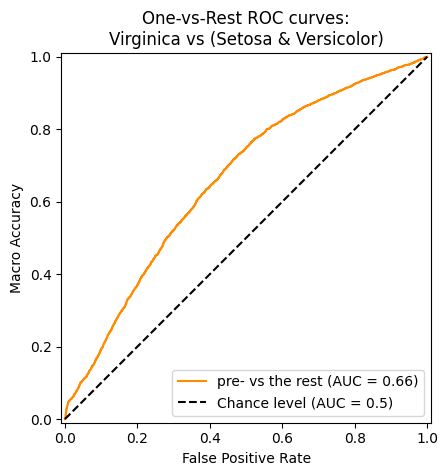

In [21]:
def local():
    from sklearn.metrics import roc_auc_score 
    import matplotlib.pyplot as plt
    
    from sklearn.metrics import RocCurveDisplay
    
    display = RocCurveDisplay.from_predictions(
        out[0][-1],
        out[0][-2],
        name=f"pre- vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="Macro Accuracy",
        title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
    )


local()

In [60]:
def local():
    from sklearn.metrics import balanced_accuracy_score
    return balanced_accuracy_score(out[0][-1], [ int(s>.1) for s in out[0][-2]])
local()

0.6242117531591216

In [151]:
def local():
    import torch
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.metrics import balanced_accuracy_score
    
    df = pd.read_csv('data/sims_features.csv')

    preds,trues = [],[]
    for pid in sorted(set(df.participant_id)):
        X_all = df.iloc[:,7:].to_numpy()
        y_all = ((df['experience_id'] != 1) & (df['phase_id'] == 1)).astype(int).to_numpy()
    
        X_trn = X_all[df.participant_id!=pid]
        y_trn = y_all[df.participant_id!=pid]
        X_tst = X_all[df.participant_id==pid]
        y_tst = y_all[df.participant_id==pid]

        model = XGBClassifier(n_estimators=2,max_depth=7).fit(X_trn,y_trn)
        preds.extend(model.predict(X_tst))
        trues.extend(y_tst)

    print(balanced_accuracy_score(trues,preds))
local()

0.5004166685797455


In [6]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval1

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([8],[256],[(.2,.5)],[15],range(1,7)):
        model = cloudpickle.dumps(ResNetDropout(13,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(3):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv") )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval1,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,'sans_ssl', round(roc_auc_score(labels,scores),4)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 2.35 s, sys: 2.34 s, total: 4.7 s
Wall time: 4min 23s


[(8, 256, (0.2, 0.5), 15, 'sims_features1.csv', 'sans_ssl', 0.6353),
 (8, 256, (0.2, 0.5), 15, 'sims_features2.csv', 'sans_ssl', 0.5534),
 (8, 256, (0.2, 0.5), 15, 'sims_features3.csv', 'sans_ssl', 0.6492),
 (8, 256, (0.2, 0.5), 15, 'sims_features4.csv', 'sans_ssl', 0.5812),
 (8, 256, (0.2, 0.5), 15, 'sims_features5.csv', 'sans_ssl', 0.5773),
 (8, 256, (0.2, 0.5), 15, 'sims_features6.csv', 'sans_ssl', 0.5608)]

In [8]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([8],[256],[(.2,.5)],[15],[1,3]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(3):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv") )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,'with_ssl', round(roc_auc_score(labels,scores),4)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 886 ms, sys: 1.12 s, total: 2.01 s
Wall time: 2min 20s


[(8, 256, (0.2, 0.5), 15, 'sims_features1.csv', 'with_ssl', 0.6484),
 (8, 256, (0.2, 0.5), 15, 'sims_features3.csv', 'with_ssl', 0.6559)]

In [9]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval2

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([8],[256],[(.2,.5)],[30],[1,3]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(3):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv") )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval2,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)
    return [ (*k,'with_ssl', round(roc_auc_score(labels,scores),4)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 983 ms, sys: 994 ms, total: 1.98 s
Wall time: 4min 37s


[(8, 256, (0.2, 0.5), 30, 'sims_features1.csv', 'with_ssl', 0.6555),
 (8, 256, (0.2, 0.5), 30, 'sims_features3.csv', 'with_ssl', 0.6765)]

### Subjective Anxiety

In [6]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval3

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([3],[20],[(.2,.5)],[5],["sims_features1.csv","sims_features3.csv"]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval3,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,'with_ssl',roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 408 ms, sys: 408 ms, total: 816 ms
Wall time: 1min 41s


[(3, 20, (0.2, 0.5), 5, 'sims_features1.csv', 'with_ssl', 0.4769446616629838),
 (3, 20, (0.2, 0.5), 5, 'sims_features3.csv', 'with_ssl', 0.4706729421747903)]

In [3]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score
    from eval import eval3b

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([3],[20],[(.2,.5)],[5],range(1,7)):
        model = cloudpickle.dumps(ResNetDropout(13,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append((model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv"))
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval3b,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,'sans_ssl',roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 2.38 s, sys: 4.03 s, total: 6.41 s
Wall time: 1min 53s


[(3, 20, (0.2, 0.5), 5, 'sims_features1.csv', 'sans_ssl', 0.49948306212614224),
 (3, 20, (0.2, 0.5), 5, 'sims_features2.csv', 'sans_ssl', 0.4784333481245595),
 (3, 20, (0.2, 0.5), 5, 'sims_features3.csv', 'sans_ssl', 0.4632652274691817),
 (3, 20, (0.2, 0.5), 5, 'sims_features4.csv', 'sans_ssl', 0.48212262796585836),
 (3, 20, (0.2, 0.5), 5, 'sims_features5.csv', 'sans_ssl', 0.4356120202006883),
 (3, 20, (0.2, 0.5), 5, 'sims_features6.csv', 'sans_ssl', 0.41876237819591505)]

In [4]:
def local():
    import torch
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.metrics import balanced_accuracy_score

    def make_data(f):
        df2 = pd.read_csv('data/self_reports.csv')
        prt = pd.read_csv('data/participants.csv')
        df3 = pd.read_csv(f'data/{f}')

        df2 = df2[df2.phase != 'baseline']
        df2['participant_number'] = df2['PID']
        prt.participant_number = prt.participant_number.str[1:].astype(int)
        prt = prt[['participant_id','participant_number']]
        exp = pd.DataFrame([[1,'alone_video'],[2,'dyad_evaluative'],[3,'group_evaluative'],[4,'dyad_non_evaluative'],[5,'group_non_evaluative']],columns=['experience_id','experience'])
        phs = pd.DataFrame([[1,'anticipatory anxiety'],[2,'experience'],[3,'post-event']],columns=['phase_id','phase'])
        df2 = df2[['participant_number','experience','phase','calm_anx']]
        df2 = pd.merge(pd.merge(pd.merge(df2,exp),phs),prt)
        df2 = df2[['participant_id','experience_id','phase_id','calm_anx']]
        
        df4 = pd.merge(df2,df3)
        
        df4['calm_anx']  = df4['calm_anx'].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})
        #df4['calm_anx']  = df4['calm_anx'].map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

        return df4

    for i in range(1,7):
    
        Z = make_data(f'sims_features{i}.csv')

        pids = Z.participant_id
        
        X_all = Z.iloc[:,8:].to_numpy()
        y_all = Z['calm_anx'].to_numpy()

        preds,trues = [],[]
        for pid in sorted(set(df.participant_id)):
        
            X_trn = X_all[pids!=pid]
            y_trn = y_all[pids!=pid]
            X_tst = X_all[pids==pid]
            y_tst = y_all[pids==pid]
    
            model = XGBClassifier(n_estimators=20,max_depth=4).fit(X_trn,y_trn)
            preds.extend(model.predict(X_tst))
            trues.extend(y_tst)
    
        print((f"sims_features{i}",balanced_accuracy_score(trues,preds)))

local()

('sims_features1', 0.515134997965383)
('sims_features2', 0.4911839941531153)
('sims_features3', 0.5178745985197598)
('sims_features4', 0.4982381039388165)
('sims_features5', 0.48968208969000115)
('sims_features6', 0.5014174764962618)


### Pre vs Post

In [6]:
def local():
    import torch
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.metrics import balanced_accuracy_score

    def make_data():
        df = pd.read_csv('data/sims_features.csv')
        
        X = df.groupby(['participant_id','phase_id','experience_id']).head(n=-1)
        X = X.reset_index(drop=True)
        Y = df.groupby(['participant_id','phase_id','experience_id']).tail(n=-1)
        Y = Y.reset_index(drop=True)
    
        X = X[(Y['phase_id'] != 2) & (Y['experience_id'] != 1)]
        Y = Y[(Y['phase_id'] != 2) & (Y['experience_id'] != 1)]

        return X,Y

    X,Y = make_data()
    
    pids = Y.participant_id
    
    X_all = X.iloc[:,7:].to_numpy()
    y_all = (Y['phase_id'] == 1).astype(int)

    preds,trues = [],[]
    for pid in sorted(set(df.participant_id)):
    
        X_trn = X_all[pids!=pid]
        y_trn = y_all[pids!=pid]
        X_tst = X_all[pids==pid]
        y_tst = y_all[pids==pid]

        model = XGBClassifier(n_estimators=2,max_depth=3).fit(X_trn,y_trn)
        preds.extend(model.predict(X_tst))
        trues.extend(y_tst)

    print(balanced_accuracy_score(trues,preds))
    return preds,trues

p,t = local()

0.5202978376172991


In [4]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval4

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([2],[20],[(.2,.5)],[5]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval4,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 228 ms, sys: 295 ms, total: 522 ms
Wall time: 11.9 s


[(2, 20, (0.2, 0.5), 5, 0.48756000951992384)]

### Social/Not Social

In [59]:
def local():
    import torch
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import balanced_accuracy_score

    def make_data(f):
        df = pd.read_csv(f'data/{f}')
        return df[df.phase_id==2]

    for i in range(1,7):
        Z = make_data(f"sims_features{i}.csv")
        
        pids  = Z.participant_id
        X_all = Z.iloc[:,7:].to_numpy()
        y_all = (Z['experience_id'] == 1).astype(int)
    
        preds,trues = [],[]
        for pid in sorted(set(df.participant_id)):
        
            X_trn = X_all[pids!=pid]
            y_trn = y_all[pids!=pid]
            X_tst = X_all[pids==pid]
            y_tst = y_all[pids==pid]
    
            model = XGBClassifier(n_estimators=80,max_depth=4).fit(X_trn,y_trn)
            #model = RandomForestClassifier(n_estimators=100,ccp_alpha=.03,class_weight='balanced').fit(X_trn,y_trn)
            trues.extend(y_tst)
            preds.extend(model.predict(X_tst))
    
        print((f"sims_features{i}",balanced_accuracy_score(trues,preds)))

local()

('sims_features1', 0.7347963700291148)
('sims_features2', 0.8302146395156852)
('sims_features3', 0.6867343464454219)
('sims_features4', 0.78673637864612)
('sims_features5', 0.8222925457102672)
('sims_features6', 0.8556258790436005)


In [39]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval5

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([4],[128],[(.2,.2)],[30],[1,3]):
        model = cloudpickle.dumps(ResNetDropout(13,14,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(1):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv"))

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval5,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    for k,(scores,labels) in outs.items():
        print((*k,'with_ssl',round(roc_auc_score(labels,scores),4)))
        yield (*k,scores,labels)

out = list(local('cpu'))

(4, 128, (0.2, 0.2), 30, 'sims_features1.csv', 'with_ssl', 0.9007)
(4, 128, (0.2, 0.2), 30, 'sims_features3.csv', 'with_ssl', 0.8418)
CPU times: user 357 ms, sys: 400 ms, total: 756 ms
Wall time: 15.2 s


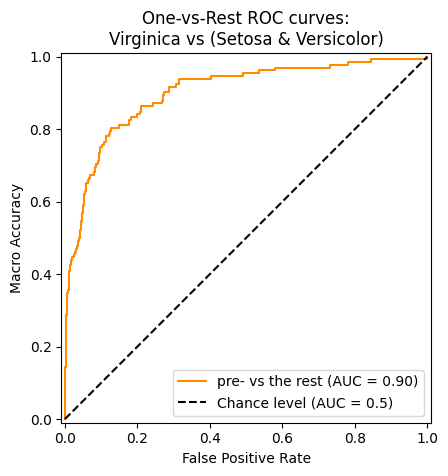

In [40]:
def local():
    from sklearn.metrics import roc_auc_score 
    import matplotlib.pyplot as plt
    
    from sklearn.metrics import RocCurveDisplay
    
    display = RocCurveDisplay.from_predictions(
        out[0][-1],
        out[0][-2],
        name=f"pre- vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="Macro Accuracy",
        title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
    )


local()

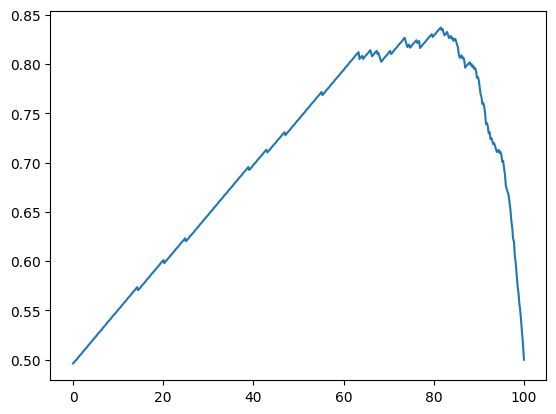

In [41]:
def local():
    from matplotlib import pyplot as plt
    from sklearn.metrics import balanced_accuracy_score
    import numpy as np

    X =  np.linspace(0,100,500)
    Y = np.percentile(out[0][-2],q=X)

    plt.plot(X,[ balanced_accuracy_score(out[0][-1], [int(s>y) for s in out[0][-2]])  for y in Y])
    
    return 
local()